Download Complete.
Extracting...
Found 2 Red bands and 2 NIR bands.
Time A (Before): LC08_L1TP_034032_20160707_20170221_01_T1_sr_band4_crop.tif
Time B (After):  LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif
Processing Images...


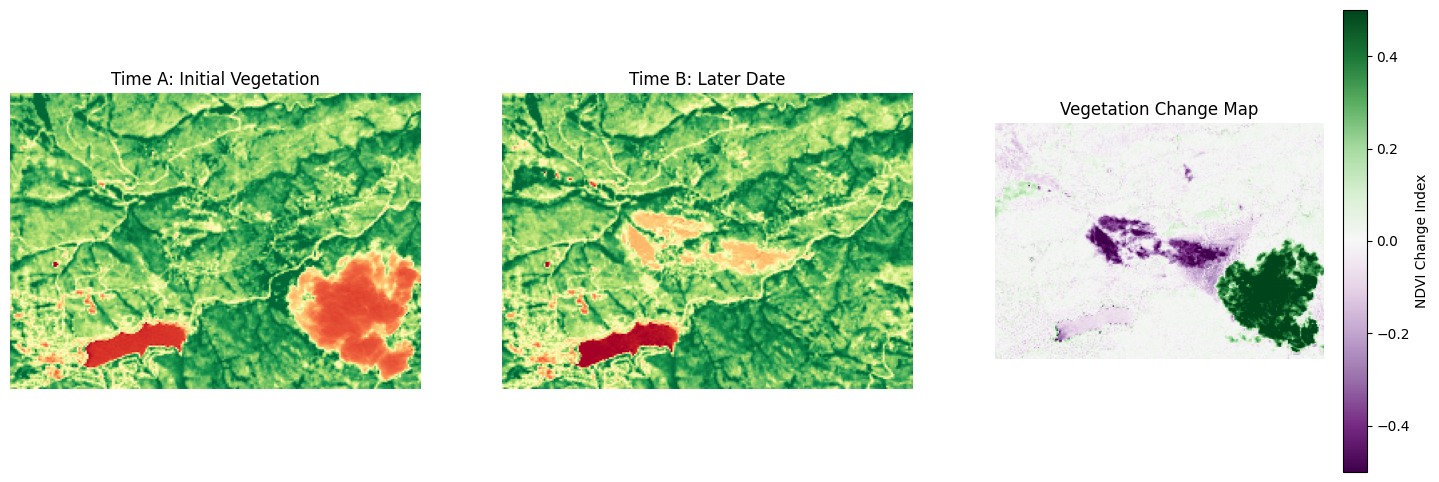

Project Pipeline Completed Successfully.


In [4]:
# --- STEP 1: INSTALL LIBRARIES ---
!pip install rasterio matplotlib numpy

# --- STEP 2: IMPORT LIBRARIES ---
import os
import requests
import zipfile
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# --- STEP 3: ROBUST DATA DOWNLOADER ---
def download_data(url, save_path):
    print("Downloading data...")
    try:
        response = requests.get(url, stream=True)
        with open(save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print("Download Complete.")
    except Exception as e:
        print(f"Download failed: {e}")

# Setup directories
data_dir = "satellite_data_final"
os.makedirs(data_dir, exist_ok=True)

# URL for the Cold Springs Fire Dataset
file_url = "https://ndownloader.figshare.com/files/10960109"
zip_path = os.path.join(data_dir, "data.zip")

# Download if not exists
if not os.path.exists(zip_path):
    download_data(file_url, zip_path)

# Extract
print("Extracting...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# --- STEP 4: AUTOMATED FILE SELECTION (The Fix) ---
# Find all files recursively
all_tifs = glob.glob(os.path.join(data_dir, "**", "*.tif"), recursive=True)

# Filter specifically for Landsat 8 images (LC08) to avoid mixing with other data
# We check for 'sr_band4' (Red) and 'sr_band5' (NIR)
red_files = sorted([f for f in all_tifs if 'LC08' in f and 'band4' in f])
nir_files = sorted([f for f in all_tifs if 'LC08' in f and 'band5' in f])

print(f"Found {len(red_files)} Red bands and {len(nir_files)} NIR bands.")

# Check if we have enough data
if len(red_files) < 2:
    print("Error: Not enough time-series data found. Checking file list:")
    print(all_tifs)
else:
    # We automatically pick the First Date (Index 0) and the Last Date (Index -1)
    # This works regardless of what the specific dates are.
    pre_red = red_files[0]
    pre_nir = nir_files[0]
    post_red = red_files[-1]
    post_nir = nir_files[-1]

    print(f"Time A (Before): {pre_red.split('/')[-1]}")
    print(f"Time B (After):  {post_red.split('/')[-1]}")

    # --- STEP 5: CALCULATE NDVI ---
    def calculate_ndvi(red_path, nir_path):
        with rasterio.open(red_path) as src:
            red = src.read(1).astype('float64')
        with rasterio.open(nir_path) as src:
            nir = src.read(1).astype('float64')
        # NDVI Formula with safety handling for zero
        return (nir - red) / (nir + red + 0.00001)

    # --- STEP 6: RUN PIPELINE ---
    print("Processing Images...")
    ndvi_pre = calculate_ndvi(pre_red, pre_nir)
    ndvi_post = calculate_ndvi(post_red, post_nir)

    # Calculate Change
    ndvi_change = ndvi_post - ndvi_pre

    # --- STEP 7: VISUALIZE ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot Time A
    ax1.imshow(ndvi_pre, cmap='RdYlGn', vmin=-0.1, vmax=0.8)
    ax1.set_title("Time A: Initial Vegetation")
    ax1.axis('off')

    # Plot Time B
    ax2.imshow(ndvi_post, cmap='RdYlGn', vmin=-0.1, vmax=0.8)
    ax2.set_title("Time B: Later Date")
    ax2.axis('off')

    # Plot Change
    # Purple = Loss. Green = Growth.
    im = ax3.imshow(ndvi_change, cmap='PRGn', vmin=-0.5, vmax=0.5)
    ax3.set_title("Vegetation Change Map")
    ax3.axis('off')

    plt.colorbar(im, ax=ax3, label="NDVI Change Index")
    plt.show()
    print("Project Pipeline Completed Successfully.")